In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np
from scipy import stats

In [2]:
def cumulate_data(df, start_index, end_index):
    x_vals = []
    y_vals = []
    
    # cumulate weekly data
    prev_col = df.iloc[:, start_index]
    prev_day = prev_col.sum()
    for i in range(start_index, end_index + 1):
        col = df.iloc[:, i]
        curr_day = col.sum()
        x_vals.append(i - start_index)
        y_vals.append(curr_day - prev_day)
        prev_day = curr_day
    
    return x_vals, y_vals

In [3]:
def normalize(dataset, population, normalization_factor):
    normalized_data = []
    
    # avoid division by zero
    if population == 0:
        population = 1

    for data in dataset:
        normalized_data.append(data / population * normalization_factor)
        
    return normalized_data

In [4]:
def conf_int(dataset):
    mean = np.mean(dataset)
    std = 1.95 * np.std(dataset)/np.sqrt(len(dataset))
    return mean - std, mean + std

# Task I

## Find most infected counties in Florida

In [5]:
# Load datasets
cases = pd.read_csv('../../Team/covid_confirmed_usafacts.csv')
deaths = pd.read_csv('../../Team/covid_deaths_usafacts.csv')
population = pd.read_csv('../../Team/covid_county_population_usafacts.csv')
presidents = pd.read_csv('../election_data/president_county_candidate.csv')

# Merge cases and population
base_cases = pd.merge(cases, population[['countyFIPS', 'population']], on='countyFIPS')
base_deaths = pd.merge(deaths, population[['countyFIPS', 'population']], on='countyFIPS')

In [6]:
# Get start and end indices
start_index = base_cases.columns.get_loc('2020-06-01')
end_index = base_cases.columns.get_loc('2021-01-03')

# Get Florida state cases DF
state_df = base_cases[base_cases['State'] == 'FL']
list_of_counties = state_df.loc[:, 'County Name']
list_of_counties_ref = list_of_counties.unique()
list_of_sums = []
num_counties = list_of_counties.unique().size

# Get Florida state deaths DF
state_df_deaths = base_deaths[base_deaths['State'] == 'FL']

# Get the sum and normalize
for i in range(1, num_counties):
    list_of_sums.append(state_df.iloc[i][end_index])
for i in range(0, num_counties-1):    
    list_of_sums = normalize(list_of_sums, state_df.iloc[i]['population'], 10000)

tracker = [-1]*5
indexes = []

# Sort
for i in range(0, num_counties-1):
    for s in range(0, 5):
        if(tracker[s] < list_of_sums[i]):
            tracker[s] = list_of_sums[i]
            break
    tracker.sort()  
    
# Get indexes
for i in range(0, 5):
    what_to_find = tracker[i]
    indexes.append(list_of_sums.index(what_to_find))

#### Trends of most at risk counties

The most at risk counties all follow the exact same pattern through covid, and reflect the nationwide pattern, as well as the state pattern. A sharp increase in cases at about a year into the pandemic, and a significantly sharper increase during the summer of 2022. 


#### Counties and Deaths graphs, trend lines, regression lines, confidence intervals, and RMSE

The confidence interval is: (8.100443770204988, 12.028588487859528)


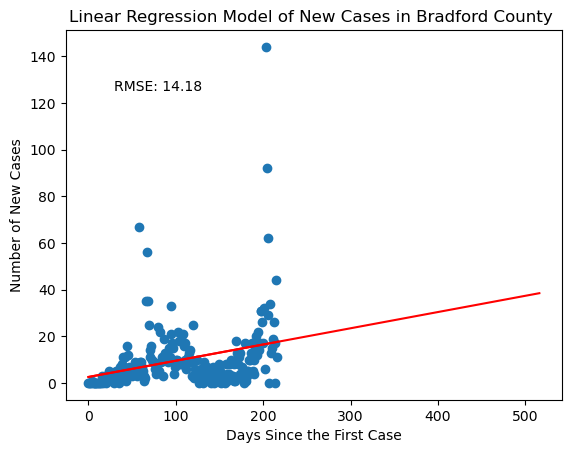

In [7]:
# Get start and end indices
start_index = state_df.columns.get_loc('2020-06-01')
end_index = state_df.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[0]
county = str(state_df.iloc[i]['County Name'])
county_1_df = state_df.iloc[i]
county_1_df = pd.DataFrame(county_1_df)

# Get cases data
county_1_df = county_1_df.transpose()
days, cases = cumulate_data(county_1_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)


# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print('The confidence interval is: ' + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

## Important Note

The trend line and linear regression line are 1:1 so I didn't add a label or anything for them, but its technically there.

The confidence interval is:(46.54396608972416, 58.66340718216524)


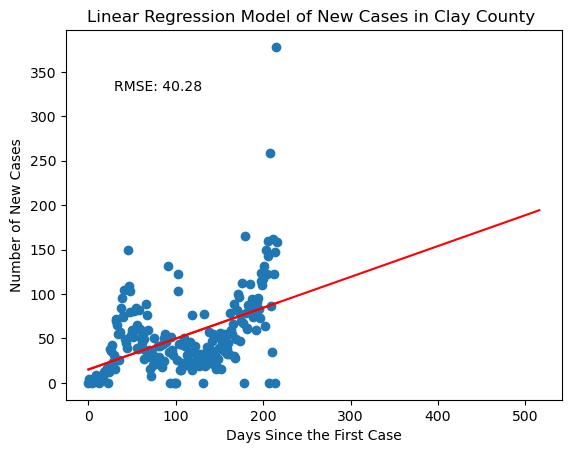

In [8]:
# Get start and end indices
start_index = state_df.columns.get_loc('2020-06-01')
end_index = state_df.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[1]
county = str(state_df.iloc[i]['County Name'])
county_2_df = state_df.iloc[i]
county_2_df = pd.DataFrame(county_2_df)

# Get cases data
county_2_df = county_2_df.transpose()
days, cases = cumulate_data(county_2_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(158.70119612257795, 207.63788433719216)


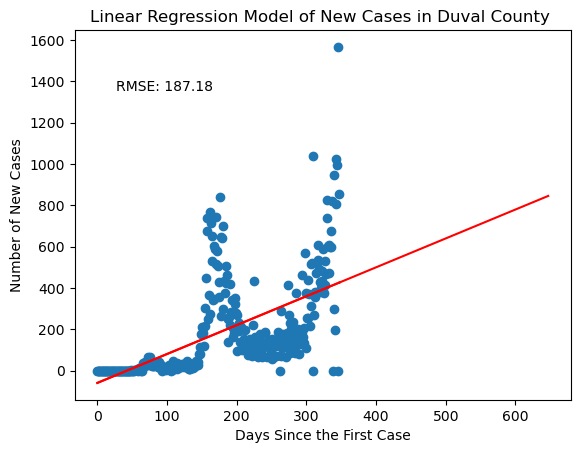

In [9]:
# Get start and end indices
start_index = state_df.columns.get_loc("2020-01-22")
end_index = state_df.columns.get_loc("2021-01-03")

# Create deaths dataframe for county
i = indexes[2]
county = str(state_df.iloc[i]['County Name'])
county_3_df = state_df.iloc[i]
county_3_df = pd.DataFrame(county_3_df)

# Get cases data
county_3_df = county_3_df.transpose()
days, cases = cumulate_data(county_3_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(-5.214931572729887, 15.353180420656154)


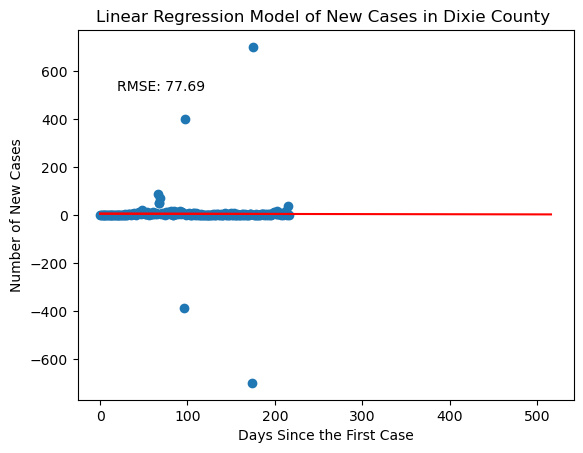

In [10]:
# Get start and end indices
start_index = state_df.columns.get_loc('2020-06-01')
end_index = state_df.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[3]
county = str(state_df.iloc[i]['County Name'])
county_4_df = state_df.iloc[i]
county_4_df = pd.DataFrame(county_4_df)

# Get cases data
county_4_df = county_4_df.transpose()
days, cases = cumulate_data(county_4_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(88.7708989524212, 106.76827155449125)


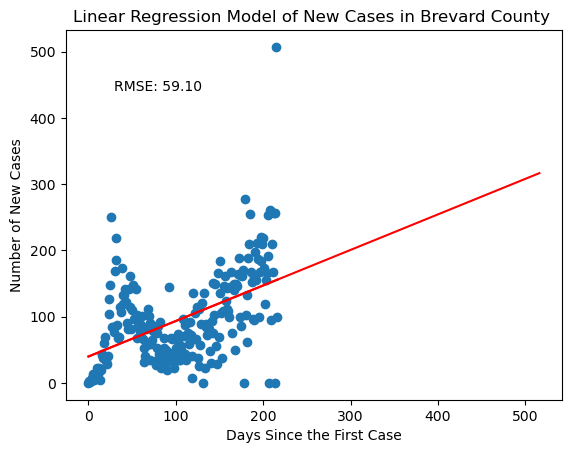

In [11]:
# Get start and end indices
start_index = state_df.columns.get_loc('2020-06-01')
end_index = state_df.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[4]
county = str(state_df.iloc[i]['County Name'])
county_5_df = state_df.iloc[i]
county_5_df = pd.DataFrame(county_5_df)

# Get cases data
county_5_df = county_5_df.transpose()
days, cases = cumulate_data(county_5_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

## Analysis of linear regression of new cases


For the scatter plot of the covid data in each county, when normalized they all look nearly the same. This makes sense, as the state follows the general pattern of the nation, and the counties follow the general pattern of the state. 

As for the linear regression, the RMSE for each was heavily dependent on how large the number of new cases daily was. The higher the numer of cases on average, the higher the RMSE. This means that the linear regression line does better on sets of data with tighter ranges, which makes sense given that its a linear equation. However, the line is ill fitting, and can only give an average of data in a given time frame, but still might be better at predicting than a polynomial line which fits the data better. 

The confidence interval is:(0.045177784336117945, 0.14837060276065625)


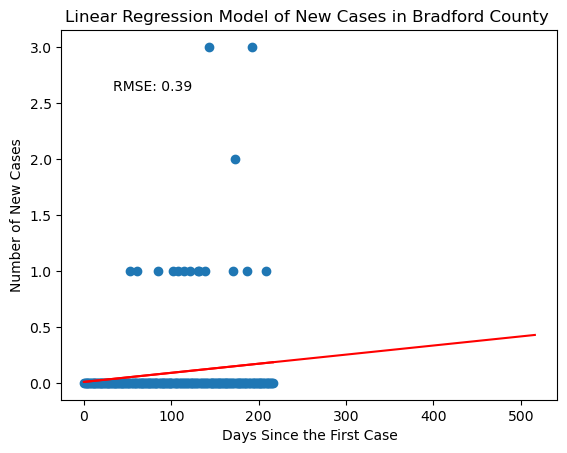

In [12]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc("2020-06-01")
end_index = state_df_deaths.columns.get_loc("2021-01-03")

# Create deaths dataframe for county
i = indexes[0]
county = str(state_df_deaths.iloc[i]['County Name'])
county_1_df_deaths = state_df_deaths.iloc[i]
county_1_df_deaths = pd.DataFrame(county_1_df_deaths)

# Get cases data
county_1_df_deaths = county_1_df_deaths.transpose()
days, cases = cumulate_data(county_1_df_deaths, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(46.54396608972416, 58.66340718216524)


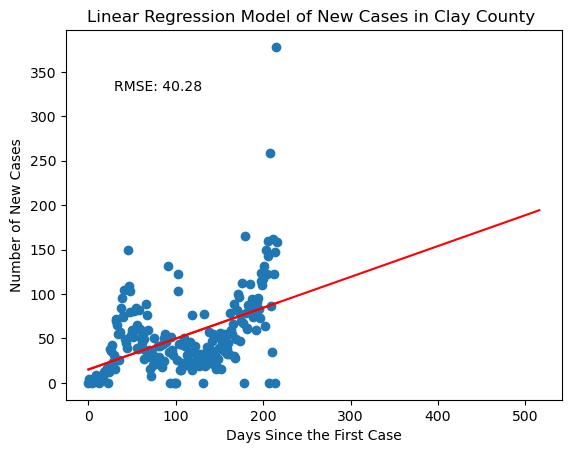

In [13]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[1]
county = str(state_df_deaths.iloc[i]['County Name'])
county_2_df_deaths = state_df.iloc[i]
county_2_df_deaths = pd.DataFrame(county_2_df_deaths)

# Get cases data
county_2_df_deaths = county_2_df_deaths.transpose()
days, cases = cumulate_data(county_2_df_deaths, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(2.624614160459082, 3.7348328441492136)


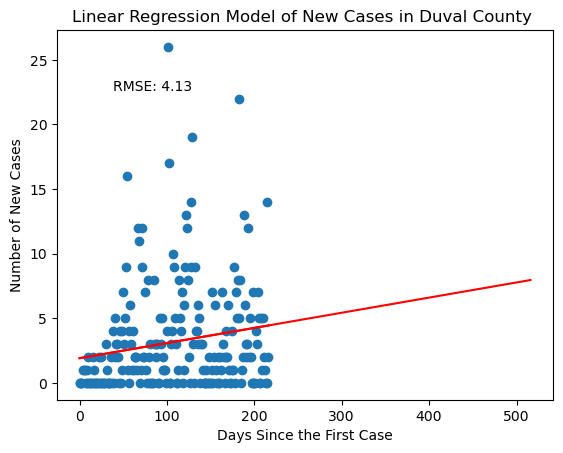

In [14]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[2]
county = str(state_df_deaths.iloc[i]['County Name'])
county_3_df_deaths = state_df_deaths.iloc[i]
county_3_df_deaths = pd.DataFrame(county_3_df_deaths)

# Get cases data
county_3_df_deaths = county_3_df_deaths.transpose()
days, cases = cumulate_data(county_3_df_deaths, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(0.01508109678588072, 0.06786821196987965)


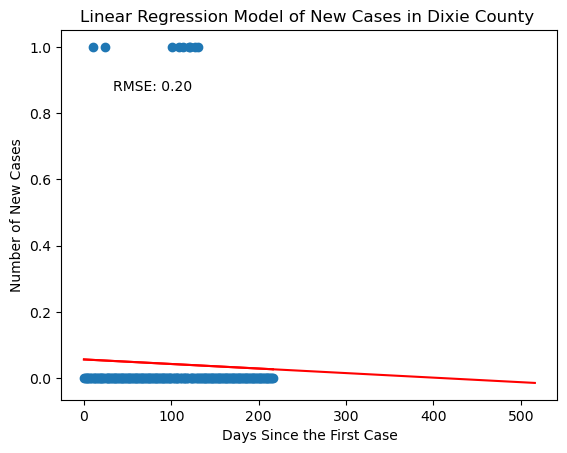

In [15]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[3]
county = str(state_df_deaths.iloc[i]['County Name'])
county_4_df_deaths = state_df_deaths.iloc[i]
county_4_df_deaths = pd.DataFrame(county_4_df_deaths)

# Get cases data
county_4_df_deaths = county_4_df_deaths.transpose()
days, cases = cumulate_data(county_4_df_deaths, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# Plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(1.9251289636407405, 2.7937650455758494)


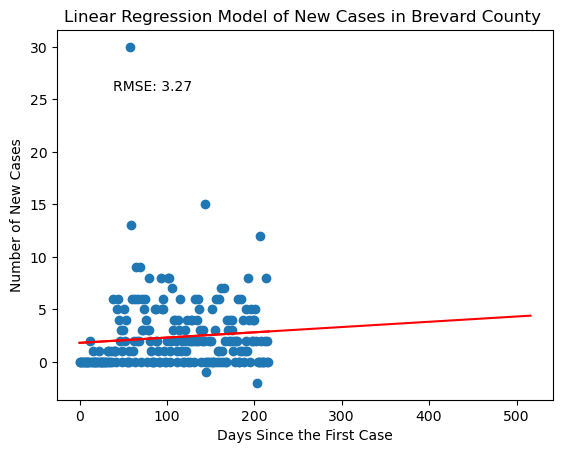

In [16]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[4]
county = str(state_df_deaths.iloc[i]['County Name'])
county_5_df_deaths = state_df_deaths.iloc[i]
county_5_df_deaths = pd.DataFrame(county_5_df_deaths)

# Get cases data
county_5_df_deaths = county_5_df_deaths.transpose()
days, cases = cumulate_data(county_5_df_deaths, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

# Make linear regression model for cases
linear_regression_cases = LinearRegression()
linear_regression_cases.fit(days.values.reshape(-1, 1), cases)

# Use model to make predictions
predictions = linear_regression_cases.predict(days.values.reshape(-1, 1))
predictions_forecast = linear_regression_cases.predict(days_forecast.values.reshape(-1, 1))

print("The confidence interval is:" + str(conf_int(cases)))

# plot data and predictions
plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Linear Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'red')

# calculate RMSE
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.8), xycoords = 'subfigure fraction')

plt.show()

### Analysis of linear regression of deaths

The RMSE on the scatterplots of deaths is quite low, which makes sense given that most people do not die from covid. It also makes sense, when there are weeks in counties where people don't die, but also weeks where data is potentially not reported timely, which has been an issue in many counties and states across this project. The very low RMSE means that the linear regression line which means it is quite accurate for the data. 

The prediction lines also seem quite accurate but they're linearly increasing, which means as the limit for the line approaches infinity so would it, which obviously would be innaccurate to the reality of the situation. 

The confidence interval is:(8.100443770204988, 12.028588487859528)


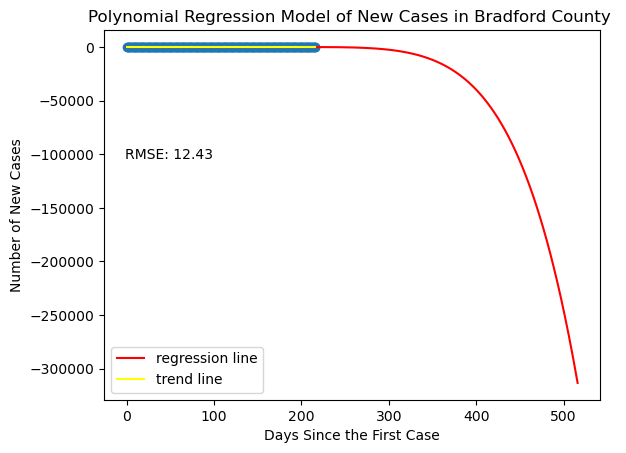

In [17]:
# Get start and end indices
start_index = state_df.columns.get_loc('2020-06-01')
end_index = state_df.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[0]
county = str(state_df.iloc[i]['County Name'])
county_1_df = state_df.iloc[i]
county_1_df = pd.DataFrame(county_1_df)

# Get cases data
county_1_df = county_1_df.transpose()

# Get cases data
days, cases = cumulate_data(county_1_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print("The confidence interval is:" + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red', label = 'regression line')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Polynomial Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(46.54396608972416, 58.66340718216524)


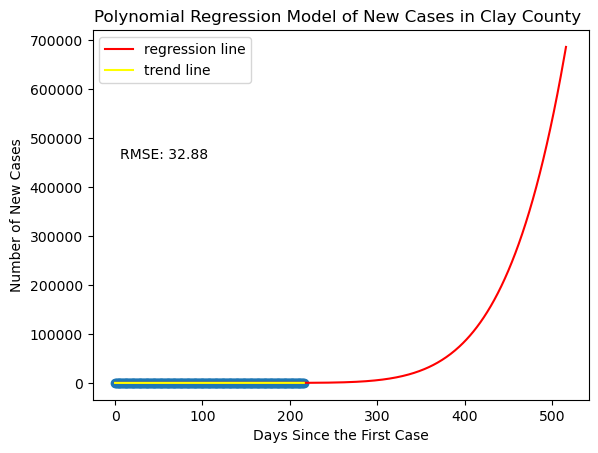

In [18]:
# get start and end indices
start_index = state_df.columns.get_loc('2020-06-01')
end_index = state_df.columns.get_loc("2021-01-03")

# Create deaths dataframe for county
i = indexes[1]
county = str(state_df.iloc[i]['County Name'])
county_2_df = state_df.iloc[i]
county_2_df = pd.DataFrame(county_2_df)

# Get cases data
county_2_df = county_2_df.transpose()
days, cases = cumulate_data(county_2_df, start_index, end_index)

days_forecast = []

# alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print("The confidence interval is:" + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red', label = 'regression line')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Polynomial Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend line')
plt.legend()

rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(253.81623417870708, 318.43261374756025)


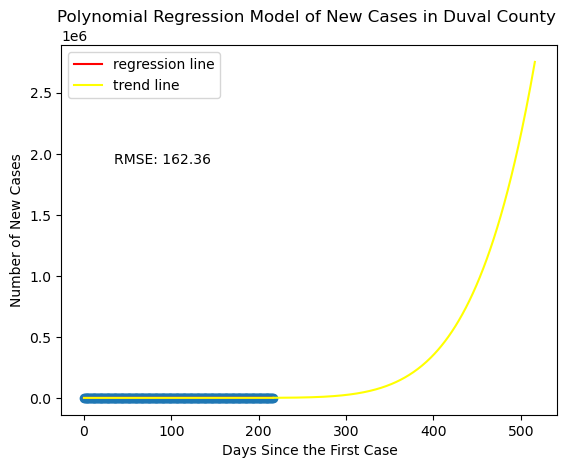

In [19]:
# Get start and end indices
start_index = state_df.columns.get_loc("2020-06-01")
end_index = state_df.columns.get_loc("2021-01-03")

# Create deaths dataframe for county
i = indexes[2]
county = str(state_df.iloc[i]['County Name'])
county_3_df = state_df.iloc[i]
county_3_df = pd.DataFrame(county_3_df)

# Get cases data
county_3_df = county_3_df.transpose()
days, cases = cumulate_data(county_3_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print("The confidence interval is:" + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red', label = 'regression line')
plt.plot(days_forecast, predictions_forecast, color = 'yellow')
plt.title('Polynomial Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label ='trend line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(-5.214931572729887, 15.353180420656154)


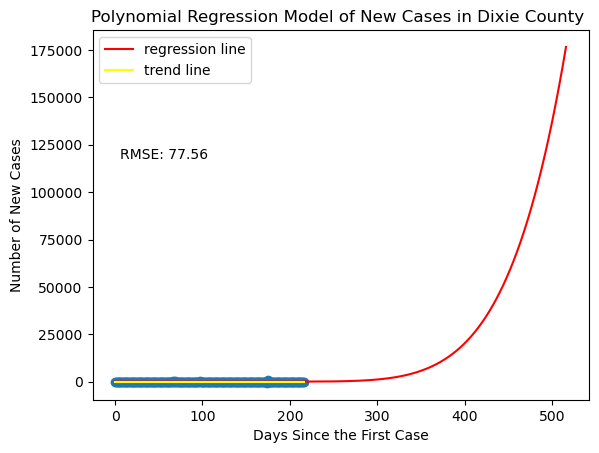

In [20]:
# Get start and end indices
start_index = state_df.columns.get_loc('2020-06-01')
end_index = state_df.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[3]
county = str(state_df.iloc[i]['County Name'])
county_4_df = state_df.iloc[i]
county_4_df = pd.DataFrame(county_4_df)

# Get cases data
county_4_df = county_4_df.transpose()
days, cases = cumulate_data(county_4_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print("The confidence interval is:" + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red', label = 'regression line')
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Polynomial Regression Model of New Cases in ' + str(county))
plt.xlabel('Days Since the First Case')
plt.ylabel('Number of New Cases')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(88.7708989524212, 106.76827155449125)


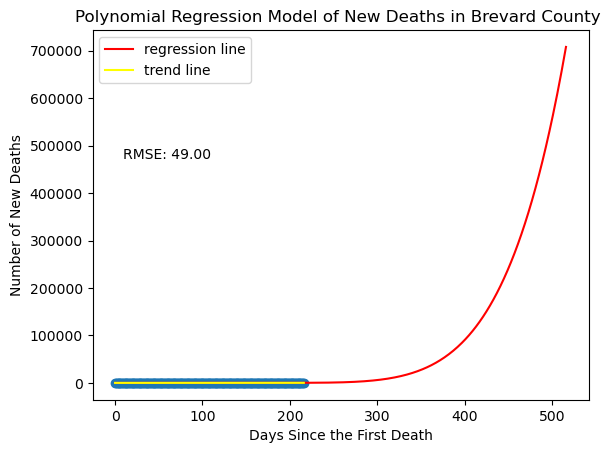

In [21]:
# Get start and end indices
start_index = state_df.columns.get_loc('2020-06-01')
end_index = state_df.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[4]
county = str(state_df.iloc[i]['County Name'])
county_5_df = state_df.iloc[i]
county_5_df = pd.DataFrame(county_5_df)

# Get cases data
county_5_df = county_5_df.transpose()
days, cases = cumulate_data(county_5_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print("The confidence interval is:" + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red', label = "regression line")
plt.plot(days_forecast, predictions_forecast, color = 'red')
plt.title('Polynomial Regression Model of New Deaths in ' + str(county))
plt.xlabel('Days Since the First Death')
plt.ylabel('Number of New Deaths')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(0.045177784336117945, 0.14837060276065625)


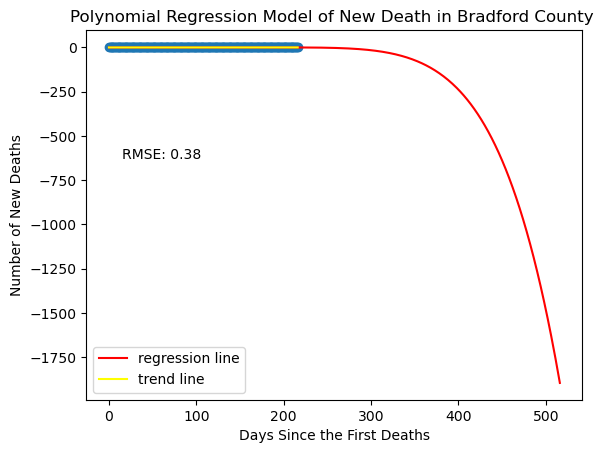

In [22]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[0]
county = str(state_df_deaths.iloc[i]['County Name'])
county_1_df = state_df_deaths.iloc[i]
county_1_df = pd.DataFrame(county_1_df)

# Get cases data
county_1_df = county_1_df.transpose()
days, cases = cumulate_data(county_1_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print("The confidence interval is:" + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red', label = 'regression line')
plt.title('Polynomial Regression Model of New Death in ' + str(county))
plt.xlabel('Days Since the First Deaths')
plt.ylabel('Number of New Deaths')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(0.5514137476666465, 0.9232406302135379)


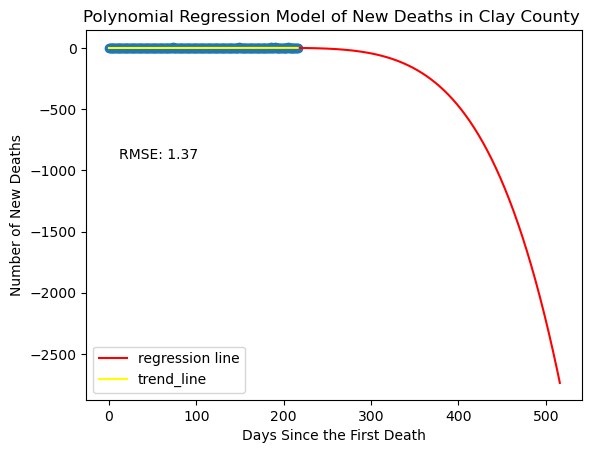

In [23]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[1]
county = str(state_df_deaths.iloc[i]['County Name'])
county_2_df = state_df_deaths.iloc[i]
county_2_df = pd.DataFrame(county_2_df)

# Get cases data
county_2_df = county_2_df.transpose()
days, cases = cumulate_data(county_2_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print("The confidence interval is:" + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red', label = 'regression line')
plt.title('Polynomial Regression Model of New Deaths in ' + str(county))
plt.xlabel('Days Since the First Death')
plt.ylabel('Number of New Deaths')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend_line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(2.624614160459082, 3.7348328441492136)


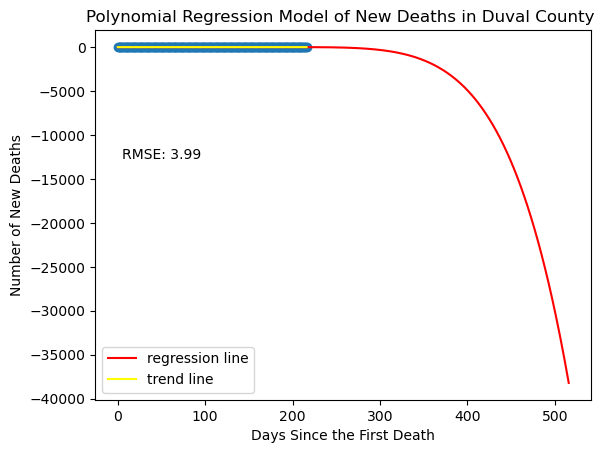

In [24]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[2]
county = str(state_df_deaths.iloc[i]['County Name'])
county_3_df = state_df_deaths.iloc[i]
county_3_df = pd.DataFrame(county_3_df)

# Get cases data
county_3_df = county_3_df.transpose()
days, cases = cumulate_data(county_3_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print('The confidence interval is:' + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red', label = 'regression line')
plt.title('Polynomial Regression Model of New Deaths in ' + str(county))
plt.xlabel('Days Since the First Death')
plt.ylabel('Number of New Deaths')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(0.01508109678588072, 0.06786821196987965)


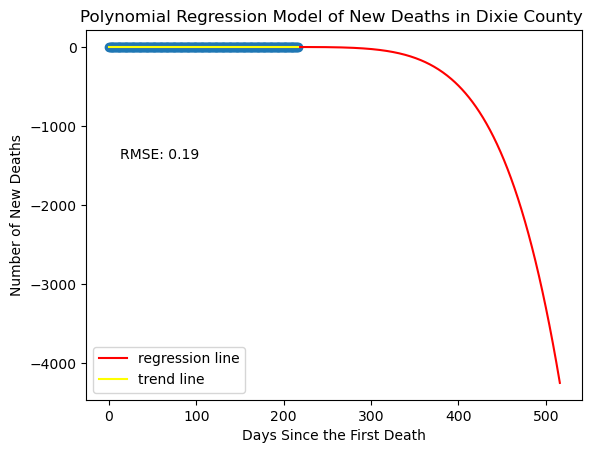

In [25]:
# Get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[3]
county = str(state_df_deaths.iloc[i]['County Name'])
county_4_df = state_df_deaths.iloc[i]
county_4_df = pd.DataFrame(county_4_df)

# Get cases data
county_4_df = county_4_df.transpose()
days, cases = cumulate_data(county_4_df, start_index, end_index)

days_forecast = []

# Alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# Convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print('The confidence interval is:' + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red', label = 'regression line')
plt.title('Polynomial Regression Model of New Deaths in ' + str(county))
plt.xlabel('Days Since the First Death')
plt.ylabel('Number of New Deaths')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

The confidence interval is:(0.01508109678588072, 0.06786821196987965)


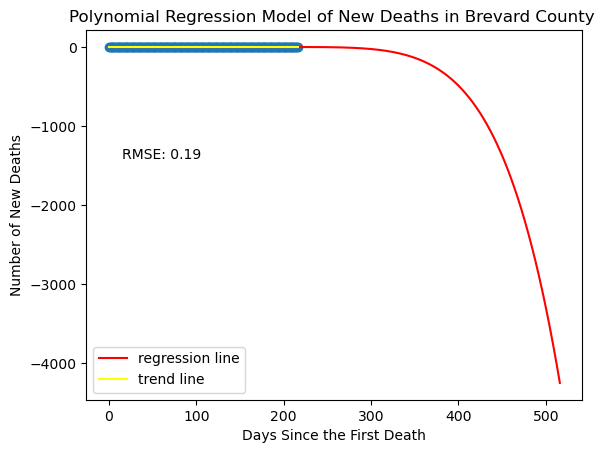

In [26]:
# get start and end indices
start_index = state_df_deaths.columns.get_loc('2020-06-01')
end_index = state_df_deaths.columns.get_loc('2021-01-03')

# Create deaths dataframe for county
i = indexes[4]
county = str(state_df_deaths.iloc[i]['County Name'])
county_5_df = state_df_deaths.iloc[i]
county_5_df = pd.DataFrame(county_5_df)

# Get cases data
county_5_df = county_5_df.transpose()

days_forecast = []

# alter days so that we can get prediction values
for i in range (0, 300):
    curr = len(days) + i
    days_forecast.append(curr)

# convert to Series
days = pd.Series(days)
cases = pd.Series(cases)
days_forecast = pd.Series(days_forecast)

transform = PolynomialFeatures(degree = 6)
days_transform = transform.fit_transform(days.values.reshape(-1, 1))
days_forecast_transform = transform.fit_transform(days_forecast.values.reshape(-1, 1))

poly_regression_cases = LinearRegression()
poly_regression_cases.fit(days_transform, cases)

predictions = poly_regression_cases.predict(days_transform)
predictions_forecast = poly_regression_cases.predict(days_forecast_transform)
print('The confidence interval is:' + str(conf_int(cases)))

plt.scatter(days, cases)
plt.plot(days, predictions, color = 'red')
plt.plot(days_forecast, predictions_forecast, color = 'red', label = 'regression line')
plt.title('Polynomial Regression Model of New Deaths in ' + str(county))
plt.xlabel('Days Since the First Death')
plt.ylabel('Number of New Deaths')

z = np.polyfit(days, cases, 1)
p = np.poly1d(z)

# Add trendline to plot
plt.plot(days, p(days), color = 'yellow', label = 'trend line')
plt.legend()
rmse = np.sqrt(mean_squared_error(cases, predictions))
plt.annotate('RMSE: %.2f' % rmse, xy = (0.2, 0.65), xycoords = 'subfigure fraction')

plt.show()

### Analysis of polynomial regression of new cases and deaths

The average RMSE on the polynomial regression was lower than on the linear regression. This means that polynomial lines tend to fit the county level data better, if only by a small margin. The degree that ended up working best after some testing was usually degree 6 in the polynomial regression. While this data might be better for modeling the data for the existing model, its predictions may be less than stellar given its on an upwards trend at the end of the graph, and it has a bias towards that trend even if the reality is much different. 

The deaths polynomial lines appeared to be very flat most of the way through for all graphs, and has a very low RMSE, which means that it is modeling that data fairly accurately. The prediction line however does not, as it continues to follow the trend of the last bits of data and trail off upward, which as we have lived through most of this time period that its predicting, has not shown to be true. 

## Stage III Hypothesis Testing

In [ ]:
# get state data
FL_cases = base_cases[base_cases['State'].str.contains('FL')]

# get start and end indices
start_index = FL_cases.columns.get_loc('2020-06-01')
end_index = FL_cases.columns.get_loc('2021-01-03')
j = 7
Counties = pd.DataFrame(columns=['County Name'])

curr_row = 0;
# 100 unique counties in FL. 
for i in range(0, len(FL_cases)):
    curr_county = FL_cases.iloc[curr_row]['County Name']
    prev_county = FL_cases.iloc[curr_row-1]['County Name']
    if(curr_county != prev_county):
        Counties.at[curr_row, 'County Name'] = curr_county
        curr_row += 1
        
Counties_Republican = Counties.copy()
Counties_Democrat = Counties.copy()
Counties_Independent = Counties.copy()      

for s in range(0, len(FL_cases)):
    county_pop = FL_cases.iloc[s]['population']      
    total = FL_cases.iloc[s][end_index]
    if county_pop > 0:
        normalized = ((total)/county_pop) * 10000
        Counties.at[s, 1] = (normalized)

#drop first row of Counties
    
FL_Votes = presidents[presidents['state'].str.contains('Florida')]    
FL_Republican_Votes = FL_Votes[FL_Votes['party'].str.contains('REP')]   

for s in range(0, 67):
    county_pop = FL_cases.iloc[s]['population']      
    votes = FL_Republican_Votes.iloc[s]['total_votes']
    if county_pop > 0:
        normalized = votes/county_pop * 10000
        Counties_Republican.at[s, 1] = (normalized)

FL_Democrat_Votes = FL_Votes[FL_Votes['party'].str.contains('DEM')] 

for s in range(0, 67):
    county_pop = FL_cases.iloc[s]['population']      
    votes = FL_Democrat_Votes.iloc[s]['total_votes']
    if county_pop > 0:
        normalized = votes/county_pop * 10000
        Counties_Democrat.at[s, 1] = (normalized)

Counties = Counties.drop(0)
Counties_Republican = Counties_Republican.drop(0)
Counties_Democrat = Counties_Democrat.drop(0)

#Perform Correlation
print('Republican Correlation: ')
print(Counties.corrwith(Counties_Republican, axis = 0))
print('Democrat Correlation: ')
print(Counties.corrwith(Counties_Democrat, axis = 0))

#### New Correlation 

There is actually stronger negative correlation this time but both  major political parties are nearly equal in this so it still essentially, according to this test alone, means there is no impact on what political party is in control of area. 

In [ ]:
stat, pvalue = stats.ttest_ind(Counties[1], Counties_Republican[1], equal_var = False )
print(stat)
print(pvalue)

stat, pvalue = stats.ttest_ind(Counties[1], Counties_Democrat[1], equal_var = False )
print('T value is: ' + str(stat))
print('The p-value is: ' + str(pvalue))

#### What does this mean?

Null Hypothesis: There is no correlation between how a county voted in the 2020 presidential election and covid trends

Well, since the p value (probability that the t value occurred by chance) is less than .05 (5%), and is in fact a tenth of a percent, we do reject the Null Hypothesis. This means that at least in Florida, there is some Correlation between who a county voted for (regarding major political parties), and how they fared during covid. 

These findings are consistent with the findings of the previous test. Contrary to the correlation test, the t test however does seem to indicate that it is much more impactful if a county in Florida voted Republican as opposed to Democrat in the 2020 presidential election. In my previous report I cited a larger unwillingness to take vaccines in Republican voters, which could be a cause as to why this is the case.

However, further tests and analysis would need to be conducted to come up with anything conclusive, to the affirmative of the null hypothesis or against it. 
